In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Setup

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
print("Current Cuda Device: {}".format(torch.cuda.current_device()))
print("Device 0 name: {}".format(torch.cuda.get_device_name(0)))

Current Cuda Device: 0
Device 0 name: NVIDIA GeForce GTX 1060


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)
        self.linear = nn.Linear(21632, 500)
        self.linear2 = nn.Linear(500, 10)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
#         self.stack = nn.Sequential(
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.relu(x)
        logits = self.linear2(x)
        return logits

In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear): Linear(in_features=21632, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=10, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr = 0.005)  

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Testing on Public MNIST Dataset

In [10]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [11]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [12]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


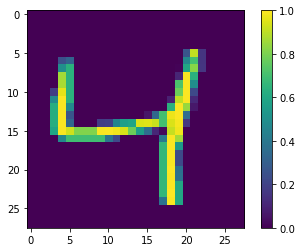

Ground truth: 4


In [13]:
# Sample visualization
n = 2  # slice
plt.imshow(X[n][0], interpolation='nearest')
plt.colorbar()
plt.show()
print("Ground truth: {}".format(y[n]))

In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305229  [    0/60000]
loss: 0.211503  [ 6400/60000]
loss: 0.211823  [12800/60000]
loss: 0.159003  [19200/60000]
loss: 0.100671  [25600/60000]
loss: 0.201812  [32000/60000]
loss: 0.128192  [38400/60000]
loss: 0.172958  [44800/60000]
loss: 0.328848  [51200/60000]
loss: 0.111870  [57600/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.080121 

Epoch 2
-------------------------------
loss: 0.065831  [    0/60000]
loss: 0.146562  [ 6400/60000]
loss: 0.076810  [12800/60000]
loss: 0.040751  [19200/60000]
loss: 0.017531  [25600/60000]
loss: 0.108972  [32000/60000]
loss: 0.109498  [38400/60000]
loss: 0.112237  [44800/60000]
loss: 0.116284  [51200/60000]
loss: 0.084429  [57600/60000]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.077717 

Epoch 3
-------------------------------
loss: 0.076190  [    0/60000]
loss: 0.046870  [ 6400/60000]
loss: 0.019136  [12800/60000]
loss: 0.084860  [19200/60000]
loss: 0.013721  [25600/60000]
loss: 0.013802  [32000/600